<a href="https://colab.research.google.com/github/ChrisKantor/Deep-Learning/blob/main/Project%202/Deep_Learning_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Deep learning model that builds on the one made in HW3 for determining an infants pain level using vital signs
#This improved model uses LSTM to better understand the sequential readings



#Run these commands - NECCESARY to use the GPU
# export CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
# export LD_LIBRARY_PATH=${CUDNN_PATH}/lib

#To connect to local runtime: jupyter lab --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

In [3]:
#import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import os
from matplotlib import pyplot as plt
import PIL
from tensorflow import keras

#needed for peephole lstm cell as tensorflow doesn't have native support yet
!pip install tensorflow_addons
import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# dir = 'Deep Learning/Project 2/'
# data_dir = "data/"


## Mount Google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Project 2/data/'


import os
print(os.getcwd())

Num GPUs Available:  0
Mounted at /content/drive
/content


# Data Preprocessing

In [5]:
#store a list of dataframes representing the data from the csv files we read in
#after reading in all of the csv files as dataframes, iterate through them, cleaning up the data and normalizing the inputs


#Should we normalize on a dataframe level or a dataset level?


data = []


#use the os library to iterate through all files in the current path
for (root,dirs,files) in os.walk(data_dir, topdown=True):
  #open each CSV file, we don't want to open any other type of file
  for f in files:
    if f.endswith(".csv"):
      with open(os.path.join(root, f), mode ='r') as csvFile:

        #read in the csv file
        csvData = csv.reader(csvFile)

        #store the data temporarily before we turn it into a pandas dataframe
        temp = []


        #check if each row is valid
        #one way to tell if the data is invalid is if the label is NOT [0, 1, 2]. This means there was something wrong with one of the sensors at the time of capture
        #another way is to check if the heart rate, respiratory rate, or o2 level is too low or too high
        #for heart Rate, we want a range of 40 - 200
        #for Respiratory Rate, we want a range of 15 - 90
        #for o2 level, we want a rate of 80 - 100

        for row in csvData:
          try:
            if row[4] in "012" and (int(row[1]) >= 40 and int(row[1]) <= 200) and (int(row[2]) >= 15 and int(row[2]) <= 90) and (int(row[3]) >= 80 and int(row[3]) <= 100):   #data is valid, so add it to the main csv
              #row[0] just stores the row # in the csv file, so it is not needed in the training dataset
              temp.append([int(row[1]), int(row[2]), int(row[3]), int(row[4])])

          #Catches errors that occur when an element cannot be parsed into an integer. In this case the row is invalid so we can skip it
          except ValueError:
            continue

        #if this valid and cleaned sequence is NOT empty, add it to our dataset
        if len(temp) > 0:
          df = pd.DataFrame(temp, columns = ['Heart Rate', 'Respiratory Rate', 'O2 Level', 'Label'])
          data.append(df)

print(len(data))

487


In [6]:
#count sequence lengths and how often they appear
freqMap = {}
for d in data:
  if d.shape not in freqMap.keys():
    freqMap[d.shape] = 1

  else:
    freqMap[d.shape] += 1

for key, value in freqMap.items():
    print(f'{key} -> {value}')


#split data into training/validation sets using an 90/10 split
data = np.asarray(data, dtype="object")
np.random.shuffle(data)

trainData, valData = np.split(data, [int(0.90*len(data))])

print(len(trainData), len(valData))

#remove the labels from the trainingData and validation data, also storing them as a list
#we don't need the entire column of labels, just the first rows label
trainLabels = []
valLabels = []

for df in trainData:
  label = df['Label'].iloc[0]    #get the first rows label, and use it for this whole sequence
  df.drop('Label', axis=1, inplace=True)
  trainLabels.append(label)

for df in valData:
  label = df['Label'].iloc[0]    #get the first rows label, and use it for this whole sequence
  df.drop('Label', axis=1, inplace=True)
  valLabels.append(label)

trainLabels = np.asarray(trainLabels).astype('int32')
valLabels = np.asarray(valLabels).astype('int32')
print(trainData.shape, len(trainLabels))
print(valData.shape, len(valLabels))

trainLabelMap = {}
for label in trainLabels:
  if label not in trainLabelMap.keys():
    trainLabelMap[label] = 1
  else:
    trainLabelMap[label] += 1


valLabelMap = {}
for label in valLabels:
  if label not in valLabelMap.keys():
    valLabelMap[label] = 1
  else:
    valLabelMap[label] += 1

print(trainLabelMap)
print(valLabelMap)

(31, 4) -> 381
(30, 4) -> 31
(14, 4) -> 2
(29, 4) -> 21
(5, 4) -> 1
(11, 4) -> 1
(21, 4) -> 4
(4, 4) -> 1
(7, 4) -> 1
(27, 4) -> 10
(28, 4) -> 15
(25, 4) -> 4
(26, 4) -> 6
(17, 4) -> 2
(22, 4) -> 2
(24, 4) -> 2
(23, 4) -> 2
(15, 4) -> 1
438 49
(438,) 438
(49,) 49
{0: 251, 1: 160, 2: 27}
{1: 19, 0: 27, 2: 3}


In [7]:
#normalize data using only the training set
#find the min/max of each column throughout all of the dataframes in the training dataset
#save the values, then iterate through the training and validation dataset and use min-max normalization
#df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

#norm values stores the min/max of each column, initialized to min = float('inf'), max = float('-inf')
#[[Heart Rate Min, Heart Rate Max], [Respiratory Rate Min, Respiratory Rate Max], [O2 Level Min, O2 Level Max]]
normValues = [[float('inf'), float('-inf')], [float('inf'), float('-inf')], [float('inf'), float('-inf')]]

for df in trainData:
  normValues[0][0] = min(normValues[0][0], df['Heart Rate'].min())
  normValues[0][1] = max(normValues[0][1], df['Heart Rate'].max())

  normValues[1][0] = min(normValues[1][0], df['Respiratory Rate'].min())
  normValues[1][1] = max(normValues[1][1], df['Respiratory Rate'].max())

  normValues[2][0] = min(normValues[2][0], df['O2 Level'].min())
  normValues[2][1] = max(normValues[2][1], df['O2 Level'].max())

#now we have the min/max for each column across our whole dataset from our training data, so we can save this normalization, and apply it to the validation set
print(normValues)



#normalizing the data:
for df in trainData:
  df['Heart Rate'] = (df['Heart Rate'] - normValues[0][0]) / (normValues[0][1] - normValues[0][0])
  df['Respiratory Rate'] = (df['Respiratory Rate'] - normValues[1][0]) / (normValues[1][1] - normValues[1][0])
  df['O2 Level'] = (df['O2 Level'] - normValues[2][0]) / (normValues[2][1] - normValues[2][0])

for df in valData:
  df['Heart Rate'] = (df['Heart Rate'] - normValues[0][0]) / (normValues[0][1] - normValues[0][0])
  df['Respiratory Rate'] = (df['Respiratory Rate'] - normValues[1][0]) / (normValues[1][1] - normValues[1][0])
  df['O2 Level'] = (df['O2 Level'] - normValues[2][0]) / (normValues[2][1] - normValues[2][0])

[[44, 199], [15, 90], [80, 100]]


In [8]:
#Data padding
#inputs to GRU cells are in the form of [batch, timesteps, feature]
#our sequences have multiple lengths, so we need to pad this data to get all of the sequences to have a length of 31 (indices 0-30)
#we can pad the data by adding rows of 0's, and use a masking layer to ignore them when training the model

for i in range(len(trainData)):
  if trainData[i].shape[0] < 31:
    padding = pd.DataFrame(0, index=np.arange(trainData[i].shape[0], 31), columns=trainData[i].columns)
    trainData[i] = pd.concat([trainData[i], padding])

for i in range(len(valData)):
  if valData[i].shape[0] < 31:
    padding = pd.DataFrame(0, index=np.arange(valData[i].shape[0], 31), columns=valData[i].columns)
    valData[i] = pd.concat([valData[i], padding])

In [9]:
#convert dataframes into np arrays and make the whole dataset multidimensional instead of an array of dataframes for tensorflow to properly use
trainData = np.array([np.array(val) for val in trainData])
valData = np.array([np.array(val) for val in valData])

# Model Setup

In [15]:
#need to seed initialization
seed = 8312001

tf.keras.utils.set_random_seed(seed)

In [16]:
#first model uses 4 GRU layers with 16 unit each
#input is taken in the form of: [batch, timesteps, feature]

input = tf.keras.layers.Input(shape=(31, 3))
mask = tf.keras.layers.Masking(mask_value=0., input_shape=(31, 3)) (input)
x = (tf.keras.layers.LSTM(32, return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(), recurrent_regularizer = tf.keras.regularizers.l2())) (mask)
# x = (tf.keras.layers.LSTM(32, return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(), recurrent_regularizer = tf.keras.regularizers.l2())) (x)
# x = (tf.keras.layers.LSTM(32, return_sequences=True, return_state=True, kernel_regularizer = tf.keras.regularizers.l2(), recurrent_regularizer = tf.keras.regularizers.l2())) (x)
# x = (tf.keras.layers.LSTM(32, return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(), recurrent_regularizer = tf.keras.regularizers.l2())) (x)
x = (tf.keras.layers.Flatten()) (x)
x = (tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l2())) (x)
# x = (tf.keras.layers.Dropout(0.5)) (x)
# x = (tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l2())) (x)
output = (tf.keras.layers.Dense(3)) (x)

model = keras.Model(input, output, name="LSTM_Model")

In [17]:
#Peephole LSTM Model
#uses the tfa PeepholeLSTMCell, which is equivalent to the normal tf LSTMCell, but adds peephole connections
#soon to be deprecated

input = tf.keras.layers.Input(shape=(31, 3))
mask = tf.keras.layers.Masking(mask_value=0., input_shape=(31, 3)) (input)

Peep_LSTMCell = tfa.rnn.PeepholeLSTMCell(32, kernel_regularizer = tf.keras.regularizers.l2(), recurrent_regularizer = tf.keras.regularizers.l2())
rnn = tf.keras.layers.RNN(Peep_LSTMCell, return_sequences=True, return_state=True)

x = (tf.keras.layers.RNN(Peep_LSTMCell, return_sequences=True)) (mask)
# x = (tf.keras.layers.RNN(Peep_LSTMCell, return_sequences=True)) (x)
# x = (tf.keras.layers.RNN(Peep_LSTMCell, return_sequences=True, return_state=True)) (x)
# x = (tf.keras.layers.RNN(Peep_LSTMCell, return_sequences=True)) (x)
x = (tf.keras.layers.Flatten()) (x)
x = (tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l2())) (x)
# x = (tf.keras.layers.Dropout(0.5)) (x)
# x = (tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l2())) (x)
output = (tf.keras.layers.Dense(3)) (x)

peep_model = keras.Model(input, output, name="Peephole_LSTM_Model")


In [ ]:
#potential definition of peephole LSTM cell to get around using the soon to be deprecated tfa verion
#taken from here: https://github.com/tensorflow/tensorflow/blob/97f585d506cccc57dc98f234f4d5fcd824dd3c03/tensorflow/python/ops/rnn_cell.py#L353

"""Module for constructing RNN Cells."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

from six.moves import xrange  # pylint: disable=redefined-builtin

from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import embedding_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import variable_scope as vs

from tensorflow.python.ops.math_ops import sigmoid
from tensorflow.python.ops.math_ops import tanh


class RNNCell(object):
  """Abstract object representing an RNN cell.

  An RNN cell, in the most abstract setting, is anything that has
  a state -- a vector of floats of size self.state_size -- and performs some
  operation that takes inputs of size self.input_size. This operation
  results in an output of size self.output_size and a new state.

  This module provides a number of basic commonly used RNN cells, such as
  LSTM (Long Short Term Memory) or GRU (Gated Recurrent Unit), and a number
  of operators that allow add dropouts, projections, or embeddings for inputs.
  Constructing multi-layer cells is supported by a super-class, MultiRNNCell,
  defined later. Every RNNCell must have the properties below and and
  implement __call__ with the following signature.
  """

  def __call__(self, inputs, state, scope=None):
    """Run this RNN cell on inputs, starting from the given state.

    Args:
      inputs: 2D Tensor with shape [batch_size x self.input_size].
      state: 2D Tensor with shape [batch_size x self.state_size].
      scope: VariableScope for the created subgraph; defaults to class name.

    Returns:
      A pair containing:
      - Output: A 2D Tensor with shape [batch_size x self.output_size]
      - New state: A 2D Tensor with shape [batch_size x self.state_size].
    """
    raise NotImplementedError("Abstract method")

  @property
  def input_size(self):
    """Integer: size of inputs accepted by this cell."""
    raise NotImplementedError("Abstract method")

  @property
  def output_size(self):
    """Integer: size of outputs produced by this cell."""
    raise NotImplementedError("Abstract method")

  @property
  def state_size(self):
    """Integer: size of state used by this cell."""
    raise NotImplementedError("Abstract method")

  def zero_state(self, batch_size, dtype):
    """Return state tensor (shape [batch_size x state_size]) filled with 0.

    Args:
      batch_size: int, float, or unit Tensor representing the batch size.
      dtype: the data type to use for the state.

    Returns:
      A 2D Tensor of shape [batch_size x state_size] filled with zeros.
    """
    zeros = array_ops.zeros(
        array_ops.pack([batch_size, self.state_size]), dtype=dtype)
    zeros.set_shape([None, self.state_size])
    return zeros


class BasicRNNCell(RNNCell):
  """The most basic RNN cell."""

  def __init__(self, num_units):
    self._num_units = num_units

  @property
  def input_size(self):
    return self._num_units

  @property
  def output_size(self):
    return self._num_units

  @property
  def state_size(self):
    return self._num_units

  def __call__(self, inputs, state, scope=None):
    """Most basic RNN: output = new_state = tanh(W * input + U * state + B)."""
    with vs.variable_scope(scope or type(self).__name__):  # "BasicRNNCell"
      output = tanh(linear([inputs, state], self._num_units, True))
    return output, output


class LSTMCell(RNNCell):
  """Long short-term memory unit (LSTM) recurrent network cell.

  This implementation is based on:

    https://research.google.com/pubs/archive/43905.pdf

  Hasim Sak, Andrew Senior, and Francoise Beaufays.
  "Long short-term memory recurrent neural network architectures for
   large scale acoustic modeling." INTERSPEECH, 2014.

  It uses peep-hole connections, optional cell clipping, and an optional
  projection layer.
  """

  def __init__(self, num_units, input_size,
               use_peepholes=False, cell_clip=None,
               initializer=None, num_proj=None,
               num_unit_shards=1, num_proj_shards=1):
    """Initialize the parameters for an LSTM cell.

    Args:
      num_units: int, The number of units in the LSTM cell
      input_size: int, The dimensionality of the inputs into the LSTM cell
      use_peepholes: bool, set True to enable diagonal/peephole connections.
      cell_clip: (optional) A float value, if provided the cell state is clipped
        by this value prior to the cell output activation.
      initializer: (optional) The initializer to use for the weight and
        projection matrices.
      num_proj: (optional) int, The output dimensionality for the projection
        matrices.  If None, no projection is performed.
      num_unit_shards: How to split the weight matrix.  If >1, the weight
        matrix is stored across num_unit_shards.
      num_proj_shards: How to split the projection matrix.  If >1, the
        projection matrix is stored across num_proj_shards.
    """
    self._num_units = num_units
    self._input_size = input_size
    self._use_peepholes = use_peepholes
    self._cell_clip = cell_clip
    self._initializer = initializer
    self._num_proj = num_proj
    self._num_unit_shards = num_unit_shards
    self._num_proj_shards = num_proj_shards

    if num_proj:
      self._state_size = num_units + num_proj
      self._output_size = num_proj
    else:
      self._state_size = 2 * num_units
      self._output_size = num_units

  @property
  def input_size(self):
    return self._input_size

  @property
  def output_size(self):
    return self._output_size

  @property
  def state_size(self):
    return self._state_size

  def __call__(self, input_, state, scope=None):
    """Run one step of LSTM.

    Args:
      input_: input Tensor, 2D, batch x num_units.
      state: state Tensor, 2D, batch x state_size.
      scope: VariableScope for the created subgraph; defaults to "LSTMCell".

    Returns:
      A tuple containing:
      - A 2D, batch x output_dim, Tensor representing the output of the LSTM
        after reading "input_" when previous state was "state".
        Here output_dim is:
           num_proj if num_proj was set,
           num_units otherwise.
      - A 2D, batch x state_size, Tensor representing the new state of LSTM
        after reading "input_" when previous state was "state".
    """
    num_proj = self._num_units if self._num_proj is None else self._num_proj

    c_prev = array_ops.slice(state, [0, 0], [-1, self._num_units])
    m_prev = array_ops.slice(state, [0, self._num_units], [-1, num_proj])

    dtype = input_.dtype

    with vs.variable_scope(scope or type(self).__name__,
                           initializer=self._initializer):  # "LSTMCell"
      concat_w = _get_concat_variable(
          "W", [self.input_size + num_proj, 4 * self._num_units],
          dtype, self._num_unit_shards)

      b = vs.get_variable(
          "B", shape=[4 * self._num_units],
          initializer=array_ops.zeros_initializer, dtype=dtype)

      # i = input_gate, j = new_input, f = forget_gate, o = output_gate
      cell_inputs = array_ops.concat(1, [input_, m_prev])
      lstm_matrix = nn_ops.bias_add(math_ops.matmul(cell_inputs, concat_w), b)
      i, j, f, o = array_ops.split(1, 4, lstm_matrix)

      # Diagonal connections
      if self._use_peepholes:
        w_f_diag = vs.get_variable(
            "W_F_diag", shape=[self._num_units], dtype=dtype)
        w_i_diag = vs.get_variable(
            "W_I_diag", shape=[self._num_units], dtype=dtype)
        w_o_diag = vs.get_variable(
            "W_O_diag", shape=[self._num_units], dtype=dtype)

      if self._use_peepholes:
        c = (sigmoid(f + 1 + w_f_diag * c_prev) * c_prev +
             sigmoid(i + w_i_diag * c_prev) * tanh(j))
      else:
        c = (sigmoid(f + 1) * c_prev + sigmoid(i) * tanh(j))

      if self._cell_clip is not None:
        c = clip_ops.clip_by_value(c, -self._cell_clip, self._cell_clip)

      if self._use_peepholes:
        m = sigmoid(o + w_o_diag * c) * tanh(c)
      else:
        m = sigmoid(o) * tanh(c)

      if self._num_proj is not None:
        concat_w_proj = _get_concat_variable(
            "W_P", [self._num_units, self._num_proj],
            dtype, self._num_proj_shards)

        m = math_ops.matmul(m, concat_w_proj)

    return m, array_ops.concat(1, [c, m])

# Model Training

In [18]:
models = [model, peep_model]

model = peep_model

In [19]:
#our learning rate scheduler. Will gradually shrink the learning rate as training progesses to find a better converging point.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Project 2/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#early stopping callback. stop if the loss doesn't improve for 7 epochs in a row
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=5,
    start_from_epoch=20)


opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt,
              loss=loss_fn,
              metrics=['accuracy'])
model.summary()

Model: "Peephole_LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 31, 3)]           0         
                                                                 
 masking_6 (Masking)         (None, 31, 3)             0         
                                                                 
 rnn_5 (RNN)                 (None, 31, 32)            4704      
                                                                 
 flatten_4 (Flatten)         (None, 992)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                63552     
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                                 
Total params: 68451 (267.39 KB)
Trainable param

In [20]:
#train the model
#Some hyperparameter setup
batch_size = 256           #set batch size to 256
epochs = 100               #set num epochs to 100

history = model.fit(
    trainData,
    trainLabels,
    validation_data=(valData, valLabels),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/100
2/2 [==============================] - 4s 933ms/step - loss: 2.7225 - accuracy: 0.2648 - val_loss: 2.4891 - val_accuracy: 0.5510
Epoch 2/100
2/2 [==============================] - 0s 86ms/step - loss: 2.4606 - accuracy: 0.5731 - val_loss: 2.3981 - val_accuracy: 0.5510
Epoch 3/100
2/2 [==============================] - 0s 96ms/step - loss: 2.3622 - accuracy: 0.5731 - val_loss: 2.2982 - val_accuracy: 0.5510
Epoch 4/100
2/2 [==============================] - 0s 76ms/step - loss: 2.2712 - accuracy: 0.5731 - val_loss: 2.2145 - val_accuracy: 0.5510
Epoch 5/100
2/2 [==============================] - 0s 87ms/step - loss: 2.1980 - accuracy: 0.5731 - val_loss: 2.1533 - val_accuracy: 0.5510
Epoch 6/100
2/2 [==============================] - 0s 71ms/step - loss: 2.1406 - accuracy: 0.5731 - val_loss: 2.0946 - val_accuracy: 0.5510
Epoch 7/100
2/2 [==============================] - 0s 71ms/step - loss: 2.0792 - accuracy: 0.5753 - val_loss: 2.0357 - val_accuracy: 0.5510
Epoch 8/100
2/2 [==

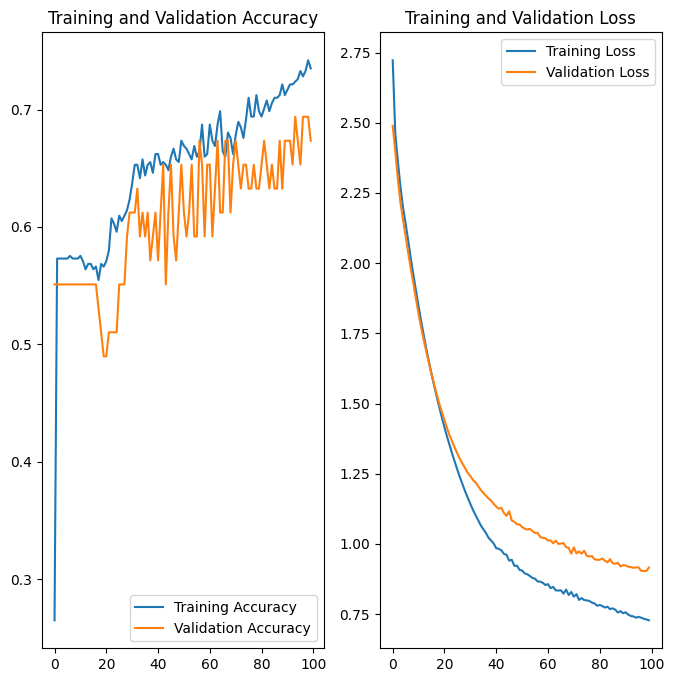

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(min(epochs, len(acc)))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
#load the best model using the callback
model.load_weights(checkpoint_filepath)

print("\n\nEvaluating Best Model\n")
#evaluation the model on the validation data
model.evaluate(valData, valLabels, verbose=2)


#Best val acc so far: 0.816 w/ 0.75 test acc



Evaluating Best Model

2/2 - 0s - loss: 0.9151 - accuracy: 0.6939 - 35ms/epoch - 17ms/step


[0.9150843620300293, 0.6938775777816772]

In [ ]:
#save the model
model.save("/content/drive/MyDrive/Colab Notebooks/Deep Learning/Project 2/bestModel_LSTM.keras")
print("Saved Model")

Saved Model


# Testing Script

In [23]:
#import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import os
from matplotlib import pyplot as plt


## Mount Google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Project 2/'

###############################################################################
#Reading data and normalization

#read test.csv, dropping the first column as it just holds the index of the rows, which we don't need
testData = pd.read_csv(data_dir + "test.csv", sep=',', usecols=[1, 2, 3, 4], names = ['Heart Rate', 'Respiratory Rate', 'O2 Level', 'Label'])


# #Normalize the test data using the normalization factors we found in the training data. Hard coded here
normValues = [[40, 200], [15, 90], [80, 100]]   #from training
testData['Heart Rate'] = (testData['Heart Rate'] - normValues[0][0]) / (normValues[0][1] - normValues[0][0])
testData['Respiratory Rate'] = (testData['Respiratory Rate'] - normValues[1][0]) / (normValues[1][1] - normValues[1][0])
testData['O2 Level'] = (testData['O2 Level'] - normValues[2][0]) / (normValues[2][1] - normValues[2][0])


###############################################################################
#Seperating normalized data into sequences

#now we need to process the data by seperating the entire data array into 31 row chunks
testData = np.array_split(testData, np.arange(31, len(testData), 31))

#pull the labels from the first row of each sequence, save it to an array, then drop the label col from this data sequence
testLabels = []
for seq in testData:
  label = seq['Label'].iloc[0]    #get the first rows label, and use it for this whole sequence
  seq.drop('Label', axis=1, inplace=True)
  testLabels.append(label)

testLabels = np.asarray(testLabels).astype('int32')

#convert dataframes into np arrays and make the whole dataset multidimensional instead of an array of dataframes for tensorflow to properly use
testData = np.array([np.array(seq) for seq in testData])



###############################################################################
#Testing model
#evaluating the model on the test data
loss, acc = model.evaluate(testData, testLabels, verbose=2)
print("Loss on test data: ", loss)
print("Accuracy on test data: ", acc)


#load the model from a saved file
bestmodel = tf.keras.models.load_model(data_dir + "bestModel_LSTM.keras")

#evaluating the model on the test data
loss, acc = bestmodel.evaluate(testData, testLabels, verbose=2)
print("Loss on test data: ", loss)
print("Accuracy on test data: ", acc)

Mounted at /content/drive
1/1 - 0s - loss: 0.8471 - accuracy: 0.7500 - 56ms/epoch - 56ms/step
Loss on test data:  0.847081184387207
Accuracy on test data:  0.75
1/1 - 3s - loss: 0.7477 - accuracy: 0.7500 - 3s/epoch - 3s/step
Loss on test data:  0.7477211952209473
Accuracy on test data:  0.75
